# Assignment 0

In [299]:
import pandas as pd
import numpy as np
from numpy import linalg as LNG
from sklearn.decomposition import PCA
import umap
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm, ListedColormap
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

np.random.seed(42)

# Supress deprecation warnings
import warnings
warnings.filterwarnings('error', category=DeprecationWarning) 

In [300]:
# Training inputs (image as vector)
X_train = pd.read_csv("data/train_in.csv", header=None).to_numpy()

# Training outputs (number that each vector represents)
Y_train = pd.read_csv("data/train_out.csv", header=None).to_numpy()

X_test = pd.read_csv("data/test_in.csv", header=None).to_numpy()
Y_test = pd.read_csv("data/test_out.csv", header=None).to_numpy()

## Calculating the center for each cloud c_d

In [301]:
def get_digit_cloud(X, Y, digit):
    # Finding all the indexes from Y_train_out related to digit
    d_indices = np.where(Y == digit)[0]

    # an array of all images related to the current d
    return X[d_indices]

In [302]:
# Stores calculated centers
# Label corresponds to index, eg. Center_0 = clouds[0]
cloud_centers = []

for d in range(10):
    cloud_d = get_digit_cloud(X_train, Y_train, d)

    # Calculating the mean/center of each cloud
    center_d = np.mean(cloud_d, axis=0)

    # add each mean vector to clouds
    cloud_centers.append(center_d)

## Calculating center distances for each digit/label

In [303]:
distances_matrix = np.full((10,10), np.NaN)

for row_index in range(0,10):
    for column_index in range(0,10):
        if column_index == row_index or not np.isnan(distances_matrix[column_index, row_index]):
            continue

        c1 = cloud_centers[row_index]
        c2 = cloud_centers[column_index]
        
        distances_matrix[row_index, column_index] = LNG.norm(c1 - c2)

In [304]:
pd.DataFrame(distances_matrix)

,0,1,2,3,4,5,6,7,8,9
0,NaN,14.449608,9.334556,9.143734,10.769844,7.519296,8.154443,11.864555,9.907902,11.488875
1,NaN,NaN,10.125323,11.733233,10.173786,11.118800,10.614700,10.743154,10.086777,9.932094
2,NaN,NaN,NaN,8.178285,7.932541,7.906796,7.331808,8.872531,7.077516,8.887748
3,NaN,NaN,NaN,NaN,9.087608,6.118750,9.302065,8.922401,7.020425,8.354350
4,NaN,NaN,NaN,NaN,NaN,8.001517,8.782233,7.583012,7.380909,6.010408
5,NaN,NaN,NaN,NaN,NaN,NaN,6.698692,9.211954,6.967386,8.258538
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.888237,8.587222,10.440004
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.467785,5.426474
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.401166
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dimensionality Reduction

In [305]:
# def visualize(X, Y, title):
#     plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='Set1', s=5)
#     plt.colorbar()
#     plt.title(title)
#     plt.show()
def visualize(X, Y, title):
    unique_labels = sorted(set(Y.flatten()))
    label_colors = ['red', 'blue', 'grey', 'purple', 'yellow', 'green', 'brown', 'pink', 'black', 'orange']
    for d, label in enumerate(unique_labels):
        cloud_d = (Y.flatten() == label)
        # X-axis
        x = X[cloud_d, 0]
        # Y-axis
        y = X[cloud_d, 1]
        plt.scatter(x, y, c=[label_colors[d]], label=str(label), s=5)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()
def visualize_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", square=True)
    plt.title("Confusion Matrix (Count)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.show()

### PCA

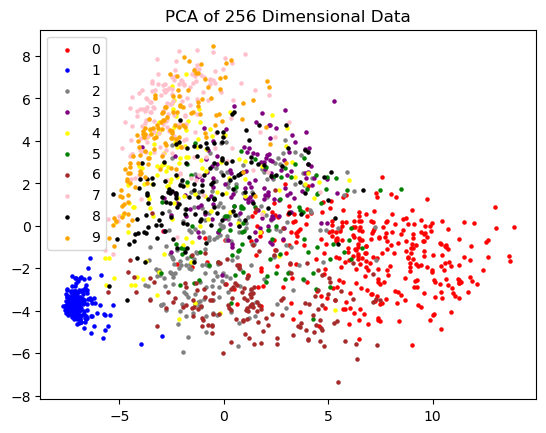

In [306]:
# Initiaze PCA
pca = PCA(n_components=2, random_state=42)

# Fit PCA to data
clouds_PCA = pca.fit_transform(X_train)

#show data
visualize(clouds_PCA, Y_train, "PCA of 256 Dimensional Data")
    

### U-MAP

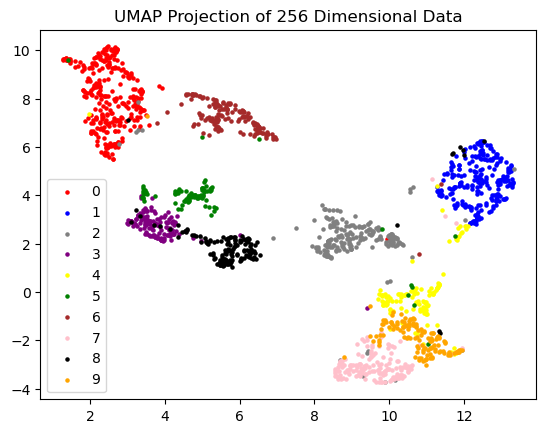

In [307]:
# initialize UMAP
umap_reducer = umap.UMAP(random_state=42)

# Fit UMAP model to data
clouds_umap = umap_reducer.fit_transform(X_train)

# show data
visualize(clouds_umap, Y_train, "UMAP Projection of 256 Dimensional Data")

### T-SNE

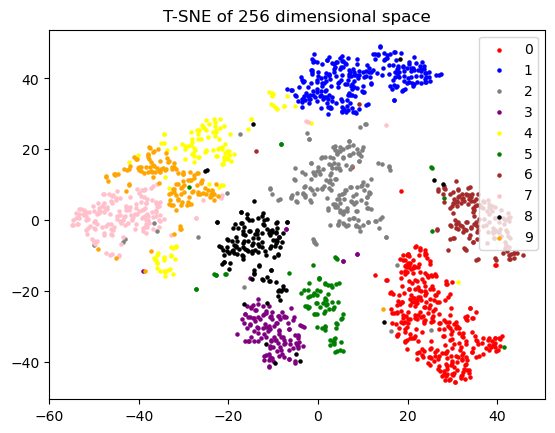

In [308]:
#Initialize T-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42)

# Fit TSNE model to data
cloud_tsne = tsne.fit_transform(X_train)

#show data
visualize(cloud_tsne, Y_train, "T-SNE of 256 dimensional space")


### Define Nearest Mean Classifier

In [309]:
def nearest_mean_classifier(new_vectors):
    Y_predict = []

    for v in new_vectors:
        distances_to_clouds = [LNG.norm(v-center) for center in cloud_centers]

        # Returns the label for the first closest cloud
        Y_predict.append(np.argmin(distances_to_clouds))
    return Y_predict

### Train K-Nearest-Neighbor Classifier

In [310]:
knn = KNeighborsClassifier(41)
knn.fit(X_train, np.ravel(Y_train))

KNeighborsClassifier(n_neighbors=41)

## Testing NearestMeanClassifier & KNearestNeighborClassifier accuracy

In [311]:
def get_accuracy(X, Y, classifier):
    correct = 0

    Y_predict = classifier(X)

    for y_predict, y in zip(Y_predict, Y):
        if y_predict == y:
            correct+=1
     
    accuracy_score(Y, Y_predict)
    return round(correct / X.shape[0] * 100, 2)

# def get_accuracy(X, Y, classifier):
#     return round(accuracy_score(Y, classifier(X)) * 100, 2)


### Accurracy on training set

In [312]:
nm_acc = get_accuracy(X_train, Y_train, nearest_mean_classifier)
print(f'Nearest Mean accuracy on training set: {nm_acc}%')

knn_acc = get_accuracy(X_train, Y_train, knn.predict)
print(f'KNN accuracy on training set: {knn_acc}%')

Nearest Mean accuracy on training set: 86.35%
KNN accuracy on training set: 88.99%


### Accurracy on test set

In [313]:
nm_acc = get_accuracy(X_test, Y_test, nearest_mean_classifier)
print(f'Nearest Mean accuracy on test set: {nm_acc}%')

knn_acc = get_accuracy(X_test, Y_test, knn.predict)
print(f'KNN accuracy on test set: {knn_acc}%')

Nearest Mean accuracy on test set: 80.4%
KNN accuracy on test set: 84.4%


### Confusion Matrix

Nearest Mean confusion matrix on the train sets


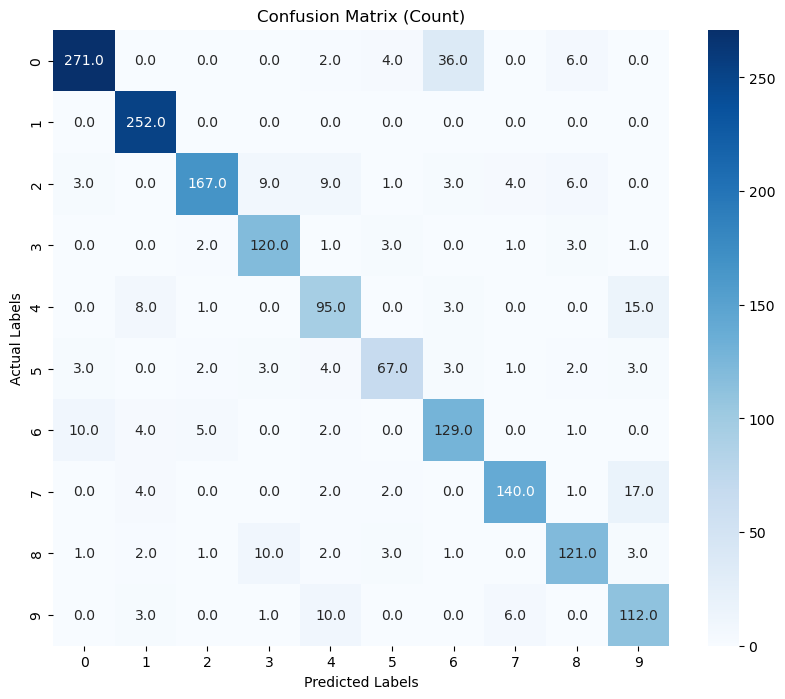

Nearest Mean confusion matrix on the test sets


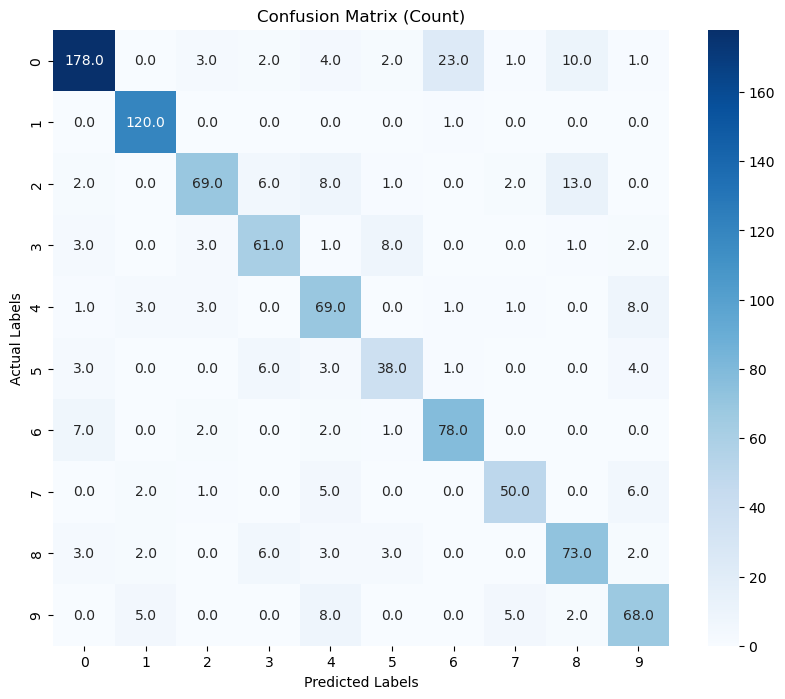

KNN confusion matrix on the train sets


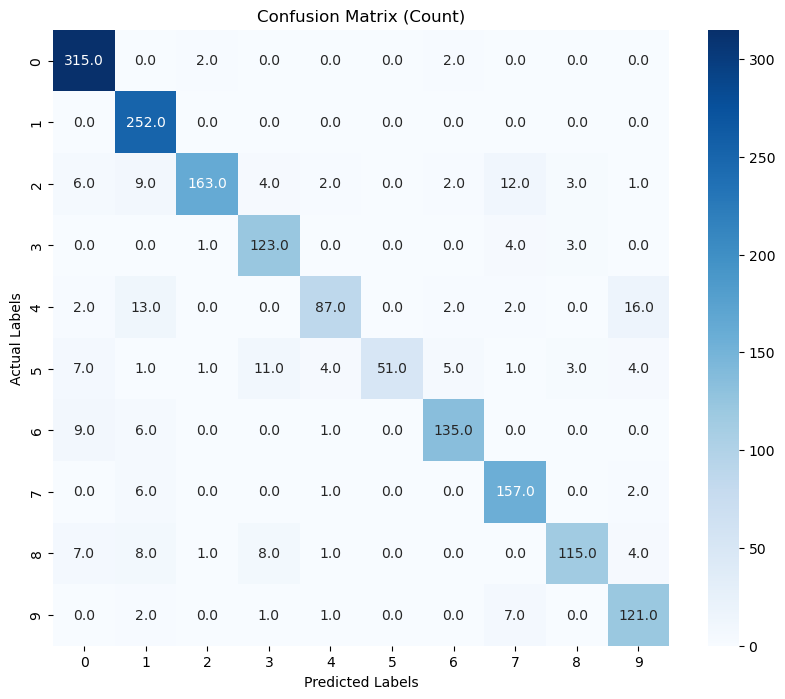

KNN confusion matrix on the test sets


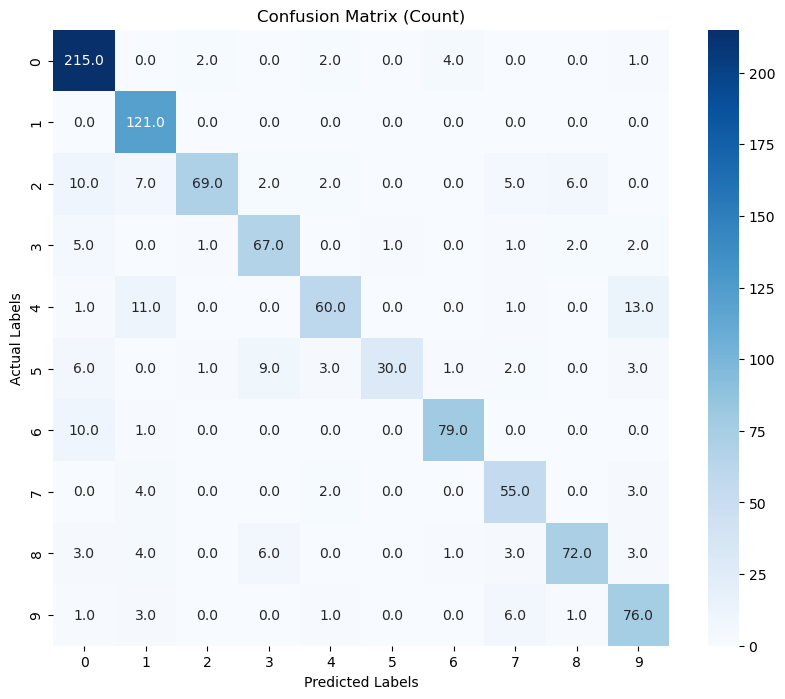

In [314]:
Y_predict_nmc = nearest_mean_classifier(X_train)
Y_predict_knn = knn.predict(X_train)
Y_test_predict_nmc = nearest_mean_classifier(X_test)
Y_test_predict_knn = knn.predict(X_test)

confusion_matrix_nmc = confusion_matrix(Y_train, Y_predict_nmc)
confusion_matrix_nmc_test = confusion_matrix(Y_test, Y_test_predict_nmc)

confusion_matrix_knn = confusion_matrix(Y_train, Y_predict_knn)
confusion_matrix_knn_test = confusion_matrix(Y_test, Y_test_predict_knn)

print(f'Nearest Mean confusion matrix on the train sets')
visualize_confusion_matrix(confusion_matrix_nmc)
print(f'Nearest Mean confusion matrix on the test sets')
visualize_confusion_matrix(confusion_matrix_nmc_test)

print(f'KNN confusion matrix on the train sets')
visualize_confusion_matrix(confusion_matrix_knn)
print(f'KNN confusion matrix on the test sets')
visualize_confusion_matrix(confusion_matrix_knn_test)


![](delta-rule1.png)

In [315]:
# slide page 13 lecture 2
# sigmoid function: ϕ(x)=1/(1+exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ϕ(x)=1/(1+exp(-x)) we have: ϕʹ(x)=ϕ(x)(1-ϕ(x))=output(1-output)
# so once we know ϕ(x) we also know ϕʹ(x) !
def sigmoid_derivative(x):
    return x * (1 - x)

# initialize random weights, multiply by 0.01 to get small values for improving learning rate
weights = np.random.randn(257, 10) * 0.1

def perceptron(input, labels, alpha, epochs):
    np.random.seed(42) 
    w = weights
    for epoch in range(epochs):
        for key in range(input.shape[0]):
            output = np.dot(input[key], w)
            output_sigmoid = sigmoid(output)

            target = np.zeros(10)
            target[labels[key]] = 1

            error = sigmoid_derivative(
                output_sigmoid) * (target - output_sigmoid)

            # update weights
            w = w + alpha * np.outer(input[key], error)

        if epoch % 10 == 0:
            # Compute accuracy for training set
            output_training = np.dot(input, w)
            predictions = np.argmax(sigmoid(output_training), axis=1)
            accuracy = np.mean(predictions == labels)
            print(f"Epoch {epoch}, Training Set Accuracy: {accuracy}")

            # Compute accuracy for test set
            output_test = np.dot(np.hstack([X_test, np.ones((X_test.shape[0], 1))]), w)
            predictions = np.argmax(sigmoid(output_test), axis=1)
            accuracy = np.mean(predictions == Y_test.flatten())
            print(f"Epoch {epoch}, Test Set Accuracy: {accuracy} \n****************************************")

alpha = 0.01
epochs = 100

perceptron(
    # add bias to input
    np.hstack([X_train, np.ones((X_train.shape[0], 1))]),
    Y_train.flatten(),
    alpha,
    epochs
)


Epoch 0, Training Set Accuracy: 0.8541300527240774
Epoch 0, Test Set Accuracy: 0.788 
****************************************
Epoch 10, Training Set Accuracy: 0.958406561218512
Epoch 10, Test Set Accuracy: 0.888 
****************************************
Epoch 20, Training Set Accuracy: 0.9695371997656708
Epoch 20, Test Set Accuracy: 0.894 
****************************************
Epoch 30, Training Set Accuracy: 0.974223784417106
Epoch 30, Test Set Accuracy: 0.895 
****************************************
Epoch 40, Training Set Accuracy: 0.9789103690685413
Epoch 40, Test Set Accuracy: 0.896 
****************************************
Epoch 50, Training Set Accuracy: 0.9818394844756884
Epoch 50, Test Set Accuracy: 0.894 
****************************************
Epoch 60, Training Set Accuracy: 0.9835969537199766
Epoch 60, Test Set Accuracy: 0.891 
****************************************
Epoch 70, Training Set Accuracy: 0.9853544229642648
Epoch 70, Test Set Accuracy: 0.89 
**************

# Task 3

### Declare XOR Training data

In [316]:
Y_train = np.array([
    [0],
    [1],
    [1],
    [0]
])

X_train = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
])

### Sigmoid & Derivative

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

$$
\sigma'(x) = \sigma(x)(1 - \sigma(x))
$$

In [317]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

### TanH & Derivative

$$\text{tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$
$$\text{tanh}'(x) = 1 - \text{tanh}^2(x)$$

In [318]:
# Hyperbolic Tangent
def tanh(z):
    return np.tanh(z)

def tanh_derivative(a):
    return 1.0 - a**2

### ReLU & Derivative

$$
\text{ReLU}(x) = \max(0, x)
$$

$$
\text{ReLU}'(x) = \begin{cases}
    0, & \text{if } x < 0 \\
    1, & \text{if } x \geq 0
\end{cases}
$$

In [319]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return 1.0 * (x > 0)

### Mean Squared Error

$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$

In [320]:
def mse(Y_pred, Y_true):
    return np.mean(np.square(Y_pred - Y_true))

### Building & Training the network

In [321]:
# XOR Net Utility functions

def unpack_weights(weights):
    ''''
    This function deserializes the weights received into its layers

    :param weights: Vector of serialized network weights
    
    :return w1: Weights of layer 1
    :return w2: Weights of layer 2
    :return b1: Bias of layer 1
    :return b2: Bias of layer 2
    '''

    w1 = weights[:4].reshape(2, 2)
    b1 = weights[4:6].reshape(1, 2)
    w2 = weights[6:8].reshape(2, 1)
    b2 = weights[8].reshape(1, 1)
    return w1, b1, w2, b2

def pack_weights(w1, b1, w2, b2):
    '''
    This function serializes the weights and biases of two layers into a single vector

    :param w1: Weights of layer 1
    :param b1: Bias of layer 1
    :param w2: Weights of layer 2
    :param b2: Bias of layer 2
    
    :return weights: Vector of serialized network weights
    '''

    # Flatten and concatenate the weights and biases
    weights = np.concatenate((w1.flatten(), b1.flatten(), w2.flatten(), b2.flatten()))
    return weights


def predict(w1, w2, b1, b2, activate):
    '''
    This function utilizes the provided weights to predict a output

    :param w1: Weights of layer 1
    :param w2: Weights of layer 2
    :param b1: Bias of layer 1
    :param b2: Bias of layer 2
    :param activate: Activation Function
    '''
    z1 = np.dot(X_train, w1) + b1
    a1 = activate(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = activate(z2)

    return z1, a1, z2, a2

def visualize_training(losses, activation, learning_rate = 0.1):
    '''
    This function generates a visualization of the training process, plotting the loss over epochs.

    :param losses: List of loss values during training
    :param activation: Activation function used in training
    :param learning_rate: Learning rate used in training (default: 0.1)

    This function plots the loss values across epochs to visualize the training progress. It provides insights into how the loss changes over time with the specified activation function and learning rate.
    '''

    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.title(f'{activation} Activation, learning_rate= {learning_rate}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [322]:
def grdmse(weights, activation):
        '''
        This function computes the gradient of Mean Squared Error (MSE) with respect to the weights and biases, and also calculates the loss.

        :param weights: Vector of serialized network weights
        :param activation: Tuple containing the activation function and its derivative (activation, d_activation)

        :return d_weights: Gradient of MSE with respect to the weights
        :return loss: Mean Squared Error loss
        '''

        w1, b1, w2, b2 = unpack_weights(weights)
        activate, d_activate = activation

        #Feedforward
        z1, a1, z2, a2 = predict(w1, w2, b1, b2, activate)

        # Compute Loss
        loss = mse(a2, Y_train)

        # Backpropagation
        dJ_da2 = a2 - Y_train
        da2_dz2 = d_activate(a2)
        dz2_dw2 = a1
        dJ_dw2 = np.dot(dz2_dw2.T, dJ_da2 * da2_dz2)

        dz2_da1 = w2

        dJ_da1 = np.dot(dJ_da2 * da2_dz2, dz2_da1.T)
        dJ_dw1 = np.dot(X_train.T, dJ_da1 * d_activate(a1))

        dJ_b1 = np.sum(dJ_da1 * d_activate(a1), axis=0)
        dJ_b2 = np.sum(dJ_da2 * da2_dz2, axis=0)

        d_weights = pack_weights(dJ_dw1, dJ_b1, dJ_dw2, dJ_b2)

        return d_weights, loss

In [323]:
def xor_train(weights, activation, learning_rate = 0.1, max_loss = 0, max_epochs = 10000):
    '''
    Trains the neural network with gradient descent using Mean Squared Error (MSE) loss.

    :param weights: Initial vector of serialized network weights
    :param activation: Tuple containing the activation function and its derivative (activation, d_activation)
    :param learning_rate: Learning rate for gradient descent (default: 0.1)
    :param max_loss: Maximum allowable loss for early stopping (default: 0.1)
    :param max_epochs: Maximum number of training epochs (default: 1000)

    :return weights: Trained weights of the neural network
    :return losses: List of loss values during training
    '''

    epoch = 0
    loss = 1

    losses = []
    while epoch < max_epochs and loss > max_loss:
        # Calculate partial derivatives
        d_weights, loss = grdmse(weights, activation)
        
        # Update weights
        d_w1, d_b1, d_w2, d_b2 = unpack_weights(d_weights)
        w1, b1, w2, b2 = unpack_weights(weights)

        w1 -= learning_rate * d_w1
        w2 -= learning_rate * d_w2
        b1 -= learning_rate * d_b1
        b2 -= learning_rate * d_b2

        weights = pack_weights(w1, b1, w2, b2)

        # Store loss
        losses.append(loss)

        # Update epoch
        epoch += 1
    
    return weights, losses
        

In [324]:
def xor_net(weights, activate):
    ''''
    Uses the xor network to make predictions

    :param weights: Network weights
    :param activate: Activation function 

    :return Y_pred: Vector of predictions 
    '''

    w1, b1, w2, b2 = unpack_weights(weights)
    _, _, _, Y_pred = predict(w1, w2, b1, b2, activate)

    return np.where(Y_pred < 0.5, 0, 1)

In [325]:
# Initialize weights
weights = np.random.uniform(0, 1, (9))

### Sigmoid

Accuracy: 1.0


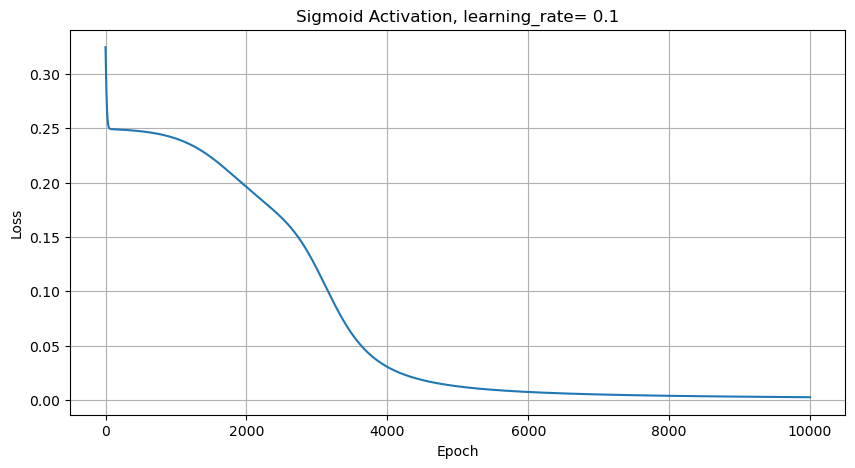

In [326]:
#Train network with sigmoid activation function
sigmoid_weights, losses = xor_train(weights=weights, activation=(sigmoid, sigmoid_derivative))

Y_pred = xor_net(sigmoid_weights, sigmoid)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Sigmoid")

Accuracy: 0.75


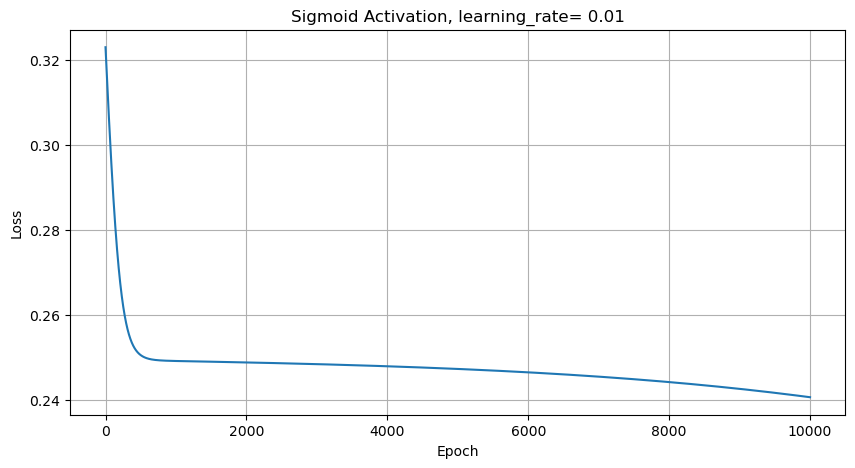

In [327]:
#Train network with sigmoid activation function
sigmoid_weights1, losses = xor_train(weights=weights, activation=(sigmoid, sigmoid_derivative), learning_rate=0.01)

Y_pred = xor_net(sigmoid_weights1, sigmoid)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Sigmoid", learning_rate=0.01)

Accuracy: 1.0


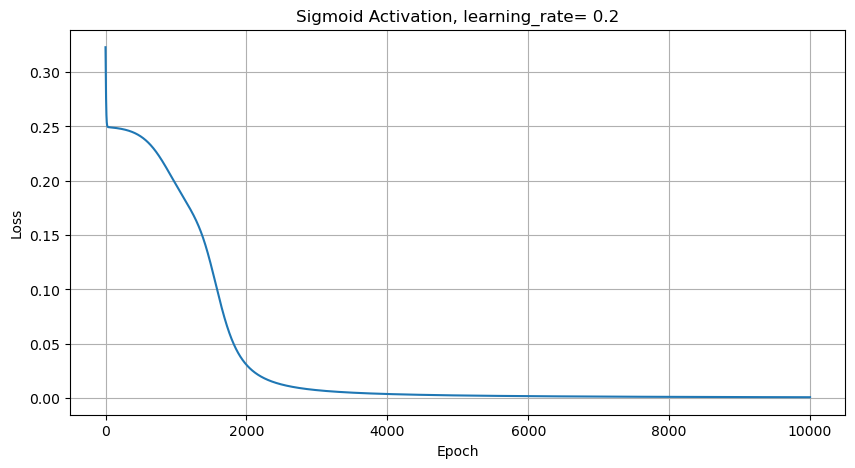

In [328]:
#Train network with sigmoid activation function
sigmoid_weights2, losses = xor_train(weights=weights, activation=(sigmoid, sigmoid_derivative), learning_rate=0.2)

Y_pred = xor_net(sigmoid_weights2, sigmoid)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Sigmoid", learning_rate=0.2)

### Hyperbolic Tangent

Accuracy: 1.0


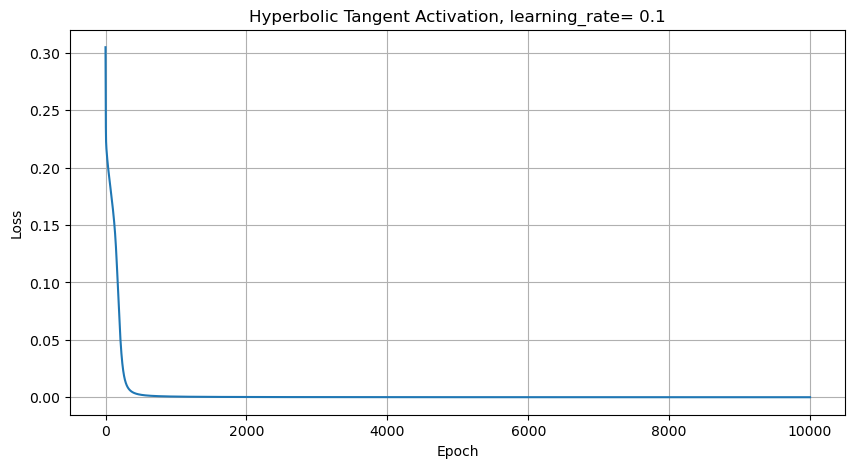

In [329]:
#Train network with sigmoid activation function
tanh_weights, losses = xor_train(weights=weights, activation=(tanh, tanh_derivative))

Y_pred = xor_net(tanh_weights, tanh)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Hyperbolic Tangent")

Accuracy: 1.0


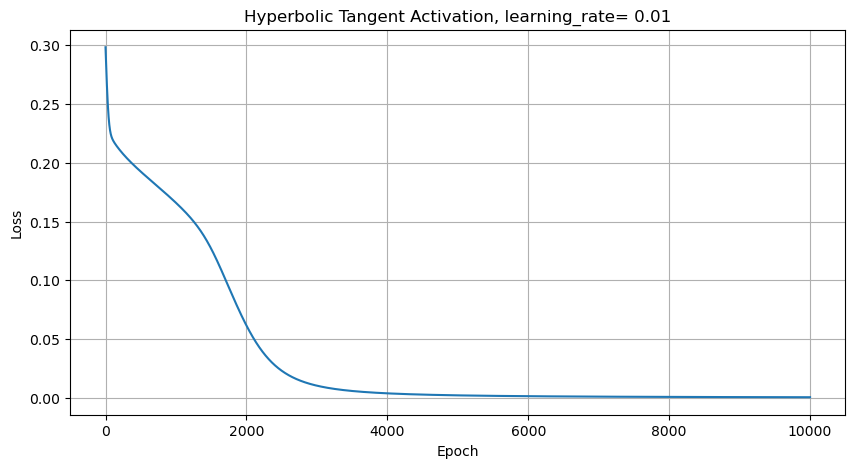

In [330]:
#Train network with sigmoid activation function
lrate = 0.01
tanh_weights1, losses = xor_train(weights=weights, activation=(tanh, tanh_derivative), learning_rate=lrate)

Y_pred = xor_net(tanh_weights1, tanh)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Hyperbolic Tangent", learning_rate=lrate)

Accuracy: 1.0


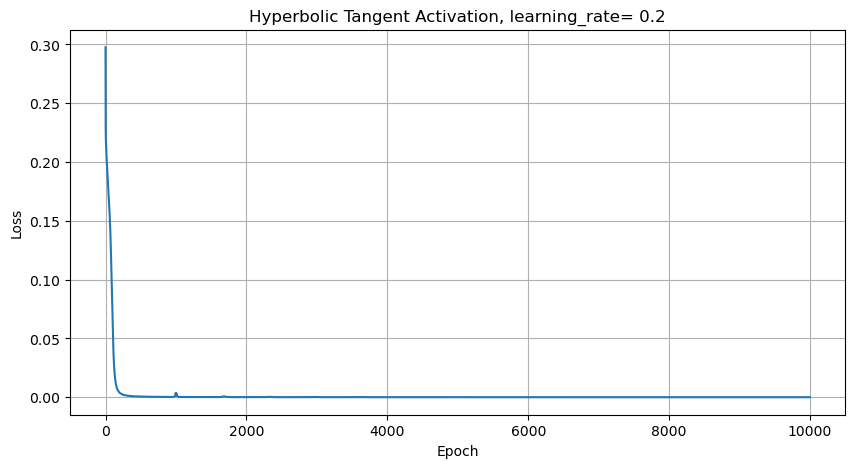

In [331]:
#Train network with sigmoid activation function
lrate = 0.2
tanh_weights2, losses = xor_train(weights=weights, activation=(tanh, tanh_derivative), learning_rate=lrate)

Y_pred = xor_net(tanh_weights2, tanh)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Hyperbolic Tangent", learning_rate=lrate)

### Rectifier Linear Unit

Accuracy: 0.5


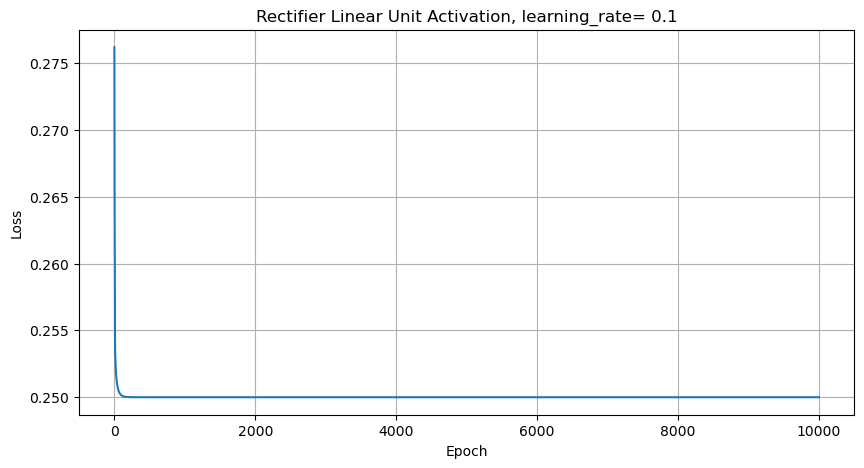

In [334]:
#Train network with sigmoid activation function
relu_weights, losses = xor_train(weights=weights, activation=(relu, relu_derivative))

Y_pred = xor_net(relu_weights, relu)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Rectifier Linear Unit")

Accuracy: 0.25


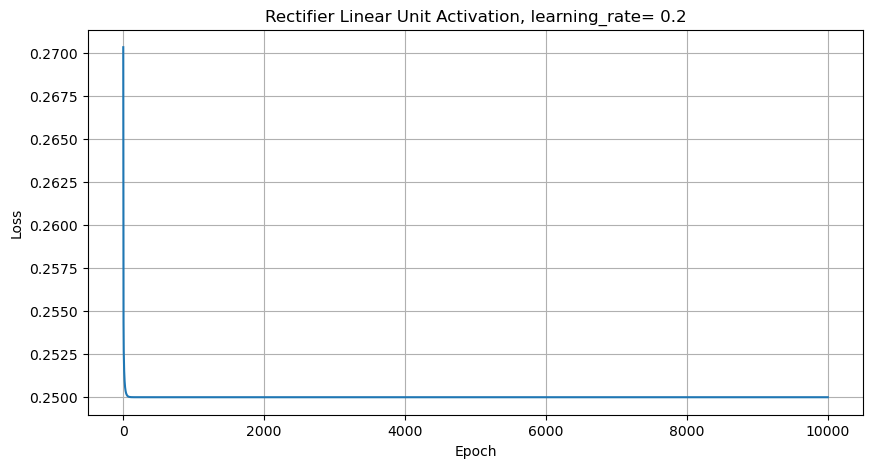

In [337]:
#Train network with sigmoid activation function
lrate = 0.2
relu_weights, losses = xor_train(weights=weights, activation=(relu, relu_derivative), learning_rate=lrate)

Y_pred = xor_net(relu_weights, relu)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Rectifier Linear Unit", learning_rate=lrate)

Accuracy: 0.5


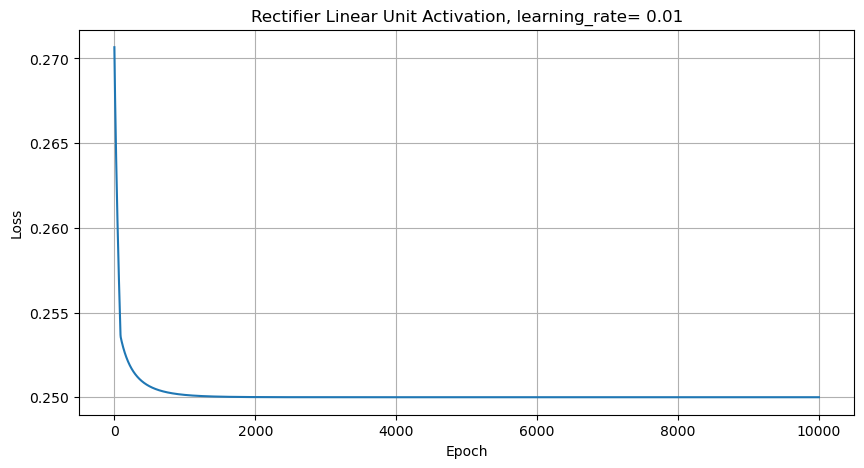

In [336]:
#Train network with sigmoid activation function
lrate = 0.01
relu_weights, losses = xor_train(weights=weights, activation=(relu, relu_derivative), learning_rate=lrate)

Y_pred = xor_net(relu_weights, relu)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Rectifier Linear Unit", learning_rate=lrate)

### Experimenting with weight initialization

In [343]:
weights = np.random.randn(9)

Accuracy: 1.0


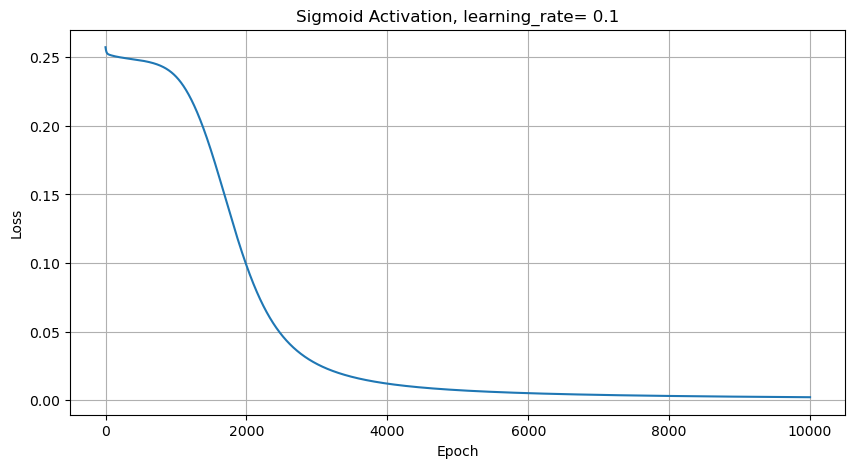

In [344]:
#Train network with sigmoid activation function
sigmoid_weights, losses = xor_train(weights=weights, activation=(sigmoid, sigmoid_derivative))

Y_pred = xor_net(sigmoid_weights, sigmoid)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Sigmoid")

Accuracy: 1.0


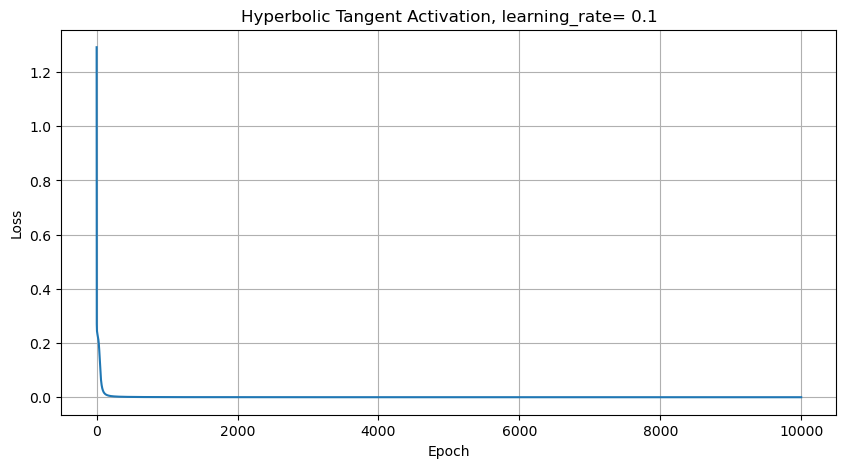

In [345]:
#Train network with sigmoid activation function
tanh_weights, losses = xor_train(weights=weights, activation=(tanh, tanh_derivative))

Y_pred = xor_net(tanh_weights, tanh)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Hyperbolic Tangent")

Accuracy: 1.0


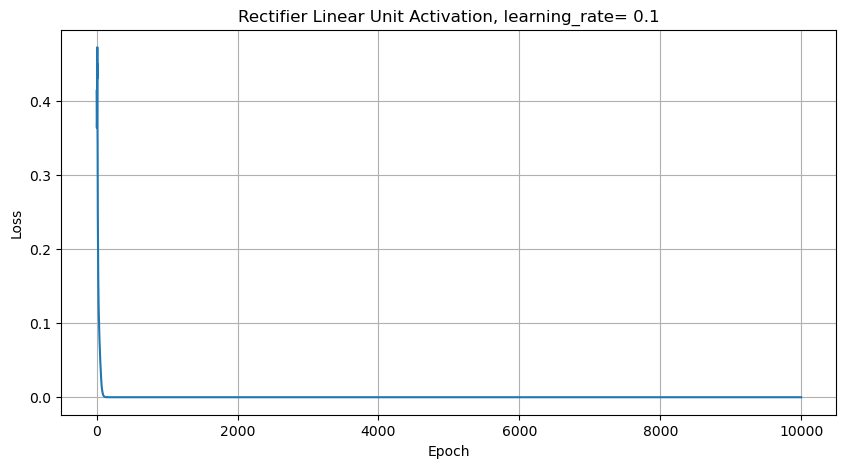

In [346]:
#Train network with sigmoid activation function
relu_weights, losses = xor_train(weights=weights, activation=(relu, relu_derivative))

Y_pred = xor_net(relu_weights, relu)
acc = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {acc}')

visualize_training(losses, "Rectifier Linear Unit")